In [ ]:
#all_no_test
#|hide
import pandas as pd
test = pd.read_csv('input/test.csv')
sample_submission = pd.read_csv('input/sample_submission.csv')
book_test = pd.read_parquet('input/book_test.parquet/stock_id=0')
trade_test = pd.read_parquet('input/trade_test.parquet/stock_id=0')

# Optiver Realized Volatility Prediction: 91st place solution

* Competition website: [https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview)
* Evaluation details: [https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview/evaluation](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview/evaluation)
* Data details: [https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview/evaluation](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/data)
* My submission: [https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1](https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1)
* [Jump to solution](#My-solution)

## What does the host of this competition want?
Predictions of the volatility of stock prices over the next 10 minute window, given trading data and book data.

## Why volatility?
Volatility is important because it is used in calculating the value of a stock option. We can trade more profitably if we are better at determining value. 

$$
\textrm{option value} = \textrm{intrinsic value} + \textrm{time value} 
$$

Intrinsic value is just the difference between the current price of the stock and strike price of the option, so it is known at the time of sale. But the time value is harder to calculate. To calculate the time value, one would need to know the probability density distribution of stock price at the expiration time of the option. The volatility of a stock's price will affect that distribution since a stock with high volatility will have larger price changes over time. Therefore if we can better predict the volatility of a stock, we can trade options more profitably. 

## Precisely, what are we being asked to predict?
### realized volatility
We will compute the log returns over all consecutive book updates and we define the **realized volatility, $\sigma$,** as the squared root of the sum of squared log returns.
$$
\sigma = \sqrt{\sum_{t}r_{t-1, t}^2}
$$
### Log returns 
Calling $S_t$ the price of the stock $S$ at time $t$, we can define the log return between $t_1$ and $t_2$ as:
$$
r_{t_1, t_2} = \log \left( \frac{S_{t_2}}{S_{t_1}} \right)
$$
Where we use **WAP** (Weighted Average Price) as price of the stock to compute log returns.
$$ WAP = \frac{BidPrice_{1}*AskSize_{1} + AskPrice_{1}*BidSize_{1}}{BidSize_{1} + AskSize_{1}} $$
where an order book looks like this: 

![order_book_1](https://www.optiver.com/wp-content/uploads/2021/05/OrderBook3.png)

## How will our predictions be scored? 
Submissions are evaluated using the root mean square percentage error, defined as:

$$\text{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} ((y_i - \hat{y}_i)/y_i)^2}$$

There will be around 100 stock ids in the test set and around 150,000 rows to predict.
With `row_id` reffering to "stock_id"-"time_id", the submission file looks like: 

In [ ]:
# print(sample_submission.to_markdown())

|    | row_id   |     target |
|---:|:---------|-----------:|
|  0 | 0-4      | 0.00304802 |
|  1 | 0-32     | 0.00304802 |
|  2 | 0-34     | 0.00304802 |

## What does the input data look like at the time of prediction? 
 

### book_test.parque
A parquet file partitioned by stock_id. Provides order book data on the most competitive buy and sell orders entered into the market. The top two levels of the book are shared. The first level of the book will be more competitive in price terms, it will then receive execution priority over the second level.

Here are the first few rows of the book data for stock_id 0:

<!-- stock_id - ID code for the stock. Not all stock IDs exist in every time bucket. Parquet coerces this column to the categorical data type when loaded; you may wish to convert it to int8.
time_id - ID code for the time bucket. Time IDs are not necessarily sequential but are consistent across all stocks.
seconds_in_bucket - Number of seconds from the start of the bucket, always starting from 0.
bid_price[1/2] - Normalized prices of the most/second most competitive buy level.
ask_price[1/2] - Normalized prices of the most/second most competitive sell level.
bid_size[1/2] - The number of shares on the most/second most competitive buy level.
ask_size[1/2] - The number of shares on the most/second most competitive sell level. -->

In [ ]:
# print(book_test.to_markdown())

|    |   time_id |   seconds_in_bucket |   bid_price1 |   ask_price1 |   bid_price2 |   ask_price2 |   bid_size1 |   ask_size1 |   bid_size2 |   ask_size2 |
|---:|----------:|--------------------:|-------------:|-------------:|-------------:|-------------:|------------:|------------:|------------:|------------:|
|  0 |         4 |                   0 |      1.00005 |      1.00059 |     0.999656 |      1.00064 |          91 |         100 |         100 |          24 |
|  1 |         4 |                   1 |      1.00005 |      1.00059 |     0.999656 |      1.00064 |          91 |         100 |         100 |          20 |
|  2 |         4 |                   5 |      1.00005 |      1.00064 |     0.999656 |      1.00089 |         290 |          20 |         101 |          15 |

### trade_test.parquet 
A parquet file partitioned by stock_id. Contains data on trades that actually executed. Usually, in the market, there are more passive buy/sell intention updates (book updates) than actual trades, therefore one may expect this file to be more sparse than the order book.

Here are the first few rows of the trade data for stock_id 0:

In [ ]:
# print(trade_test.to_markdown())

|    |   time_id |   seconds_in_bucket |   price |   size |   order_count |
|---:|----------:|--------------------:|--------:|-------:|--------------:|
|  0 |         4 |                   7 | 1.00034 |      1 |             1 |
|  1 |         4 |                  24 | 1.00005 |    100 |             7 |
|  2 |         4 |                  27 | 1.00006 |    100 |             3 |

### test.csv 
Provides the mapping between the other data files and the submission file. As with other test files, most of the data is only available to your notebook upon submission with just the first few rows available for download.

In [ ]:
# print(test.to_markdown())

|    |   stock_id |   time_id | row_id   |
|---:|-----------:|----------:|:---------|
|  0 |          0 |         4 | 0-4      |
|  1 |          0 |        32 | 0-32     |
|  2 |          0 |        34 | 0-34     |

#### Important notes about the data:

 * As stated on the [data page](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/data), Time IDs are not necessarily sequential but are consistent across all stocks. This is very important information. It means we can use information from all stocks in a given time_id, but can't create lagging features since we can't order the data by time. However, this turned out not to be completely true. The winner of the competiton used the price tick size to reverse engineer the order of the time_ids, as stated in their write up: [https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/274970](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/discussion/274970). I did not use this technique in my solution.
 

 * Data for all time_ids are given in one batch, instead of sequentially. This is not how predictions are made in the real world, where you need to make predictions and act on them before you have any data from the future. Even though the time_ids are shuffled, we can still use aggregated information accross all time_ids when making predictions. I did take advantage of this in my solution by aggregating data across all time_ids.

## My solution 
### How to reproduce results
To predict on the final test data, you must make a submission through kaggle.

The script that produces the final predictions for competition test set: [https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1/notebook?scriptVersionId=75800583](https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1/notebook?scriptVersionId=75800583)


The last link is to the last step in the pipeline. All of the model training scripts are public. They can be found in the input section of that notebook, also linked here: [https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1/data?scriptVersionId=75800583](https://www.kaggle.com/code/chrisrichardmiles/opt-inf-ensemble-final-1/data?scriptVersionId=75800583)

The rest of the pipeline is also public:

* Feature generation: [https://www.kaggle.com/chrisrichardmiles/generate-train-features-script-p13](https://www.kaggle.com/chrisrichardmiles/generate-train-features-script-p13)
* Module opt_fe.py: [https://www.kaggle.com/code/chrisrichardmiles/opt-fe](https://www.kaggle.com/code/chrisrichardmiles/opt-fe)
* Module opt_utils.py: [https://www.kaggle.com/code/chrisrichardmiles/opt-utils](https://www.kaggle.com/code/chrisrichardmiles/opt-utils)

### Simple model reproduction locally from scratch
* Requirements: 16 GB of RAM and minconda installed

I have provided a script that will process the raw input data into training features and train one of the best single models which scores 0.21986 rmspe on the test set and would place 177th in the competition. 

#### 177th place simple model  kaggle submission 
- Training: [https://www.kaggle.com/code/chrisrichardmiles/opt-train-dart-op-175-fold-0/notebook](https://www.kaggle.com/code/chrisrichardmiles/opt-train-dart-op-175-fold-0/notebook)
- Submission: [https://www.kaggle.com/code/chrisrichardmiles/opt-best-dart-inference/notebook](https://www.kaggle.com/code/chrisrichardmiles/opt-best-dart-inference/notebook)

#### Instructions to build model locally
* Clone this repository and navigate to the optiver directory: 
```
git clone https://github.com/ChrisRichardMiles/chrisrichardmiles.git
cd chrisrichardmiles/projects/optiver
```

* The competition data can be found here: [https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/overview/evaluation](https://www.kaggle.com/competitions/optiver-realized-volatility-prediction/data)
* Download data into the input folder. If you have the kaggle api installed, with your kaggle.json file in /root/.kaggle, you can run the following:
```
kaggle competitions download -p input -c optiver-realized-volatility-prediction
```
* Remove duplicate files and unzip the data
```
rm -rf input/*.parquet input/*.csv
unzip -d input -q input/optiver-realized-volatility-prediction.zip
```
* If you'd like to save the metadata and results of the model training at neptune.ai, run the following with correct edits for your neptune project name and api token: 
```
export NEPTUNE_PROJECT='neputune_username/project_name'
export NEPTUNE_API_TOKEN='YOUR_LONG_API_TOKEN'
```
* Create the conda environment
```
conda env create -f env.yml
conda activate opt
```
* Run `run.sh` to create features and train the model
```
bash run.sh
```
This will create train features as a pickle file called p13_train.pkl and then train the lightgbm-dart model, with the output stored in the folder `dart_model`

### Solution 

I used gradient boosted tree based models and neural networks. For gradient boosting, I used the [Lightgbm](https://lightgbm.readthedocs.io/en/v3.3.2/) implementation, using both standard gradient boosting and dart mode. For the neural networks, I used the tabnet architecture, implemented by [Optimo](https://github.com/Optimox), at this repository: [https://github.com/dreamquark-ai/tabnet](https://github.com/dreamquark-ai/tabnet).

* Dart paper: [https://arxiv.org/pdf/1505.01866.pdf](https://arxiv.org/pdf/1505.01866.pdf) K. V. Rashmi, Ran Gilad-Bachrach (2015)
* Tabnet paper: [https://arxiv.org/pdf/1908.07442.pdf](https://arxiv.org/pdf/1908.07442.pdf) Arik, S. O., & Pfister, T. (2019)

My final submission is a blend of predictions from 10 different models. The blend is 1/2(weighted arithmetic mean) + 1/2(weighted geometric mean). The weights are determined using the [minimize](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.minimize.html) function from scipy. All models have the same input features, generated by the `p13` function in fe.py. 

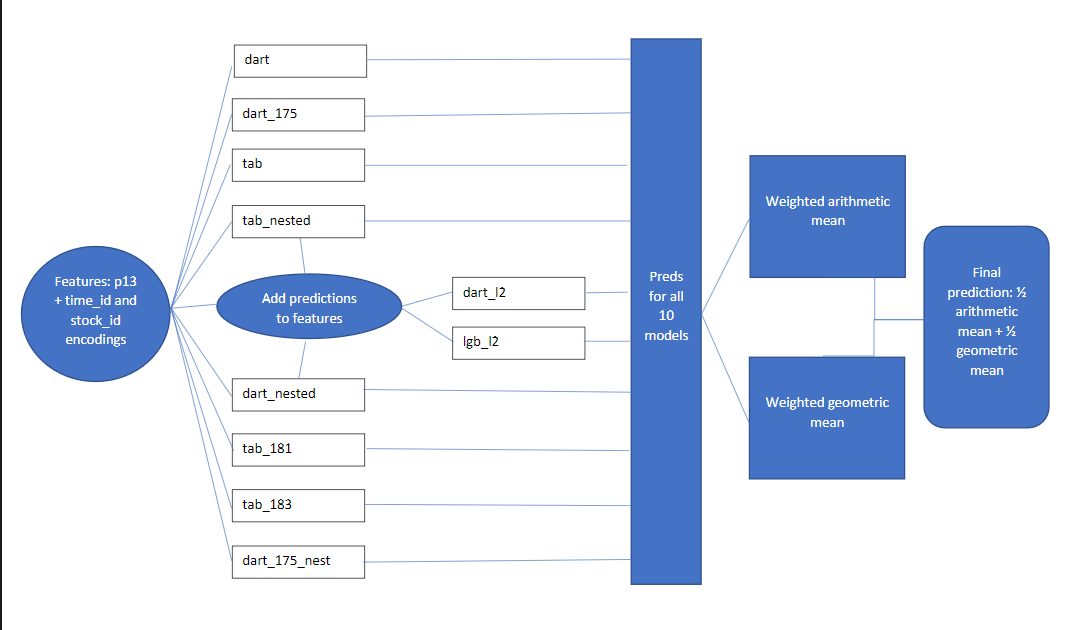

### Models

#### Regular models trained with 5-fold cross validation.
* dart: lightgbm model with dart mode, using `lgb_params`
* dart_175: lightgbm model with dart mode, using `dart_175_params`
* tab: tabnet model with `tabnet_params`
* tab_181: same as tab, except `T_0` is changed from 200 to 30 in `scheduler_params`
* tab_183: same as tab_181 except `n_steps` is changed from 2 to 3.

#### Nested models trained with nested cross validation
* tab_nested: same as tab, but nested cv.
* dart_nested: same as dart, but nested cv.
* dart_175_nested: same as dart_175, but nested cv.

#### Level 2 models:
These models have the same features as the previous models, except with added predictions from tab_nested and dart_nested
* dart_l2: same params as dart
* lgb_l2: same as dart_l2, except `boosting_type`=`gbdt`

#### Parameters 
```
lgb_params = {
        "boosting_type": "dart",
        "objective": "rmse",
        "learning_rate": .05,
        "num_leaves": 255,
        "min_data_in_leaf": 255,
        "feature_fraction": 0.8,
        "bagging_fraction": .5,
        "bagging_freq": 1,      
        "n_estimators": 10_000,
        "early_stopping_rounds": 400,
        "n_jobs": -1,
        "seed": 42,
        "verbose": -1, 
    }
    
dart_175 = {
        "boosting_type": "dart",
        "objective": "rmse",
        "learning_rate": .05,
        "num_leaves": 255,
        "min_data_in_leaf": 2 ** 10,
        "feature_fraction": 0.25,
        "bagging_fraction": .85, 
        "bagging_freq": 1,      
        "n_estimators": 10_000,
        "early_stopping_rounds": 400,
        "n_jobs": -1,
        "seed": 42,
        "verbose": -1, 
    }
    
tabnet_params = {
        'cat_emb_dim': 1,
        'n_d': ND_NA,
        'n_a': ND_NA,
        'n_steps': 2,
        'gamma': 2,
        'n_independent': 2,
        'n_shared': 2,
        'lambda_sparse': 0,
        'optimizer_fn': Adam,
        'optimizer_params': {'lr': 0.02},
        'mask_type': 'entmax',
        'scheduler_params': {
            'T_0': 200,
            'T_mult': 1,
            'eta_min': 0.0001,
            'last_epoch': -1,
            'verbose': False
        }
```

### Features

#### Top 25 features
This figure is taken from a dart model trained on a single fold. Standard lightgbm models and tabnet models also showed similar feature importance, with slight variations.
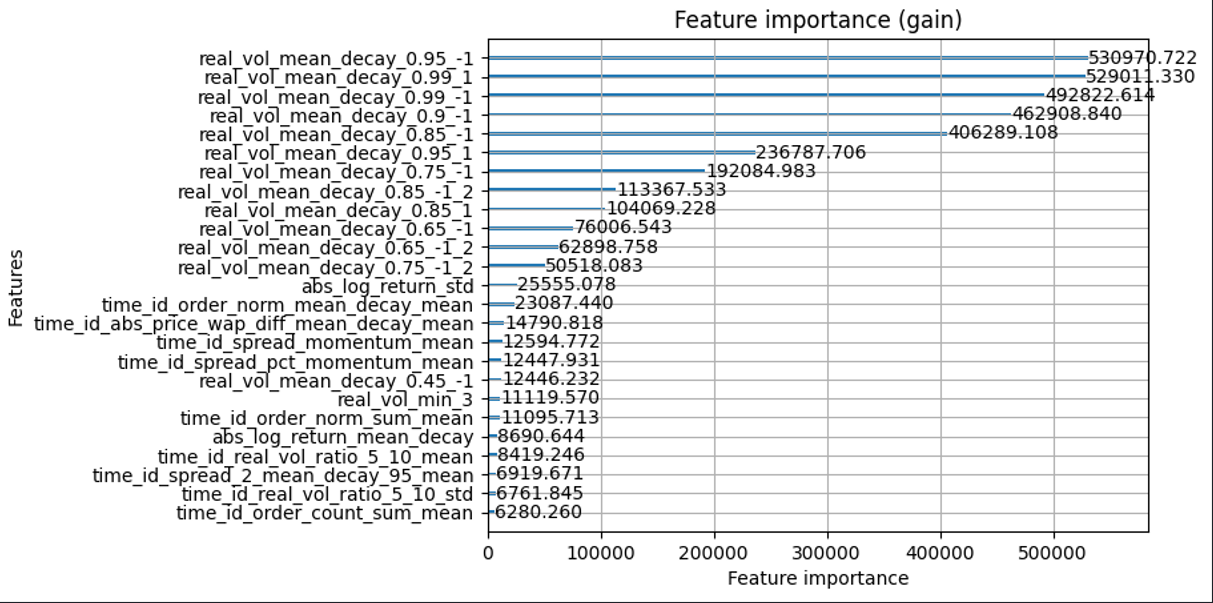

**Meaning of commonly used strings in features**
* `{time_id or stock_id}_{feature}_{mean or std}` means that we encoded the mean or standard deviation of `feature` onto each time_id or stock_id

* `{feature}_mean_decay`: Exponentially weighted mean of `feature`, with later data being higher weighted. 
* `{feature}_mean_decay_flip`: Exponentially weighted mean of `feature`, with earlier data being higher weighted. 
* `{feature}_momentum` =  `{feature}_mean_decay` / `{feature}_mean_decay_flip`. 

**Top 25 feature summary**
* **`real_vol_mean_decay_{decay factor}_{decay direction}`**: This is a weighted average of the features `real_vol_min_{minute x of range(0,9)}`. The weights are exponentially weighted by the "decay factor". The weight of the ith minute has a weight of (decay factor) ^ i. The "decay direction" indicates if the highest weight is at the beginning (1) or at the end (-1).
* **`real_vol_mean_decay_{decay factor}_{decay direction}_2`**: Just like the last feature, but using the weighted average price of the second level bid and ask book information. 
* **`real_vol_min_{minute x of range(0,9)}`**: The realized volatility calculated for each minute of the 10 minutes of input data.
* **`abs_log_return_std`**: Standard deviation of the absolute value of the log of the return = abs(log(price1 / price0)). 
* **`time_id_order_norm_mean_decay_mean`**: `order_norm` is the order count, normalized by the average order count for the stock_id. 
* **`time_id_abs_price_wap_diff_mean_decay_mean`**: `abs_price_wap_diff` is the absolute difference between the weighted average price and the price of a trade.
* **`time_id_spread_momentum_mean`**: `spread` is the difference between the ask price and bid price of the first level in the book data.
* **`time_id_spread_pct_momentum_mean`**: `spread_pct` = `spread` / `wap` (weighted average price)
* **`time_id_order_norm_sum_mean`**: `order_norm_sum` is the sum of `order_norm`. `order_norm` is the order count, normalized by the average order count for the stock_id. 
* **`abs_log_return_mean_decay`**: Absolute value of the log of the return = abs(log(price1 / price0)).
* **`time_id_real_vol_ratio_5_10_mean`**: `real_vol_ratio_5_10` is sum_0_5 / sum_6_10, where sum_0_5 is the sum of `real_vol_min_{x}` for x in the range 1 to 5 and sum_6_10 is the sum of `real_vol_min_{x}` for x in the range 6 to 10.
* **`time_id_real_vol_ratio_5_10_std`**: `real_vol_ratio_5_10` is sum_0_5 / sum_6_10, where sum_0_5 is the sum of `real_vol_min_{x}` for x in the range 1 to 5 and sum_6_10 is the sum of `real_vol_min_{x}` for x in the range 6 to 10.
* **`time_id_spread_2_mean_decay_95_mean`**: `spread_2` is the difference between the ask price and bid price of the **second** level in the book data.
* **`time_id_order_count_sum_mean`**: `order_count_sum` is total number of unique orders made in the 10 minute window of input data in a row.

#### Feature creation pipeline
 1. Create features for an individual stock with a function `p{x}` (`p13` was the final function used). 
 2. Encode mean and standard deviation of selected features onto the categorical features time_id and stock_id.
 3. Remove time_id and stock_id. 
     - time_ids would be bad features because they never appear in both train data and testing data. I also didn't want to use stock_id because I figured I could easily overfit to training data. By encoding the information and dropping time_id and stock_id, I think the models can be made more robust to shifts in data distribution.
     
##### `p13` preprocessing function steps: 
1. Load and merge book data and trade data. 
2. Calculate base features for each row (600 total, one per second over 10 minutes). 
3. Aggregate base features over the full 10 minutes of each time_id to get one row of data per time_id/stock_id combination. Aggregate functions include max_minus_min, mean, std, sum, mean_decay.
4. Create features by combining aggregate features such as f1 - f2, f1 / f2, f1 + f3.
5. Add three `dummy_x` features that are random gaussian noise. These are used to identify features that are not more useful than random noise. 

##### Encoding using `encode_cols`: 
I create `tmp` by encoding the mean or standard deviation of selected features onto time_id and stock_id. For the training data, I then use the `shake_std` variable to add random noise sampled from a gaussian distribution, whose standard deviation is eqaul to `shake_std` * (standard deviation of `tmp`). With `shake_std`=.3, I was able to obtain the same boost in cv score as I obtained with `shake_std`=0, but with a smaller difference between the training score and validation score. I did not add noise to the test data. 

I did not find using `shake`, which uses the mean of `tmp` to scale the noise distribution, to be as usefull as `shake_std`. 
```
def encode_cols(df, cols, funcs=['mean', 'std'], on='stock_id', shake=False, shake_std=False): 
    if not cols or not funcs: return df
    tmp = df.groupby(on)[cols].agg(funcs)
    tmp.columns = ['_'.join(c) for c in tmp.columns]
    tmp = tmp.add_prefix(on + '_')
    tmp =  df.join(tmp, on=on)
    if shake: 
        for c in tmp.columns: 
            if c.startswith(on + '_'):
                c_mean = tmp[c].mean()
                tmp[c] = tmp[c] + np.random.normal(scale=abs(c_mean * shake), size=len(tmp))
                
    if shake_std: 
        for c in tmp.columns: 
            if c.startswith(on + '_'):
                c_std = tmp[c].std()
                tmp[c] = tmp[c] + np.random.normal(scale=c_std * shake_std, size=len(tmp))
    return tmp 
```

### Validation
I used k-fold cross validaton with early stopping on the validation set. 

**Information leakage**: General term talking about a model that is trained with information advantages not given to the model when predicting unseen data, causing it to perform badly. For instance, if we encode a categorical variabl

**Choices for early stopping**: 
1. Use train/validation split for each fold and early stop on validation set. 
 * Pros: We risk overfitting on the validation sets. 
 * Cons: Faster experiments and I believe this is the best way to find the best "fit"
 
2. Use choice 1 and then retrain one model on the entire train set with the average (mean or median) number of iterations (no validation set). 
 * Pros: We get to use all the training data at the same time. 
 * Cons: With only one model, the risk that we missed the optimal number of training iterations. 
3. Use nested k fold, with early stopping on the inner loop. 

 * Pros: We get the "proper fit" benefit of early stopping, but our out-of-fold predictions can be made without any data leakage, which makes our cv score a more realistic estimation of errors in production. We can also use these prediction as features in other models (model stacking) since the predictions aren't made with information leakage. 
 
3. No early stopping and use large number of iterations with shrinking learning rate and or regularization. I have little experience with this but I believe it is better suited to neural networks rather than gradient boosted trees. 

In this competition I tested 1 vs 2 using both nested k-fold test sets and the public test set as validation. I found that 1 gave better results, even when I tried using a variation of 2, using many  num_iterations to retrain models, which increased computation cost but didn't improve metric.

I also tried 

#### K-fold cross validation brief explanation:
We divide the data into k equally sized "folds". For each fold, we use the data in that fold as a validation set and use the remaining data to train a model. So for each set of hyperparameters (model, features, settings etc...) we train k models. When predicting a test set or production set of data, we take an average of all k model predictions. 

* **Note on early stopping**: When we are training models, we can choose to use the validation set to choose the optimal number of training iterations (number of tree boosters for gradient boosting and number of epochs for neural nets). This comes at the risk of overconfident cross validation scores. we can also retrain a single model with all the data for training, using the average number of iterations found with early stopping. After a few experiments, judging the outcome by nested cross validation score and the public leaderboard score, I found that using early stopping worked best in this competition.

#### Nested cross validation brief explanation:
This method of cross validation allows us to get out of fold predictions on a validation set, but use a separate validation set for early stopping. The benefit is that our cross validation predictions are not "overfit" due to early stopping on the same data, giving more robust validation as well as providing features that can be used for model stacking. The drawback of this method is that you must create k * (k - 1) models, instead of just k models needed for regular k-fold cross validation.
* **example with 5 folds**:
To obtain predictions for fold_5, I train 4 models and take a mean of their predictions. Each model sees 3 of the 4 remaining folds as training data with the remaining fold is a validation set for early stopping. The training/validaton splits look like [123|4], [124|3], [134|2], [234|1].